In [1]:
import os
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

/Users/alexlakiza/py/genre-by-cover/venv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/alexlakiza/py/genre-by-cover/venv/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/alexlakiza/py/genre-by-cover/venv/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /Users/alexlakiza/py/genre-by-cover/venv/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')

In [4]:
device

device(type='mps')

In [5]:
# df = pd.read_parquet('../data/main_df.parquet')
# df = pd.read_parquet('/content/drive/MyDrive/cleaned_main_df.parquet')
df = pd.read_parquet('../data/cleaned_main_df.parquet')

In [6]:
df.columns

Index(['album_title', 'album_artist', 'album_cover_link',
       'album_cover_local_name', 'album_genres', 'deezer_artist_genre',
       'record_type', 'primary_album_genre'],
      dtype='object')

In [7]:
df[df['primary_album_genre'] == 'Rock']['album_artist'].value_counts()

Pearl Jam               199
The Rolling Stones      123
Pink Floyd               58
Queen                    53
Bruce Springsteen        50
                       ... 
The Чиж & Co              1
Tony Bennett              1
Slaughter to Prevail      1
Gojira                    1
The Living Tombstone      1
Name: album_artist, Length: 178, dtype: int64

In [8]:
df.shape

(9329, 8)

In [9]:
df = df.drop(df[df['album_artist'] == 'Pearl Jam'].index, axis=0)

In [10]:
df.shape

(9110, 8)

In [11]:
df['primary_album_genre'].value_counts()

Rock           2025
Jazz           1426
Pop            1280
Electro        1177
Rap/Hip Hop    1089
Alternative     923
R&B             777
Metal           413
Name: primary_album_genre, dtype: int64

In [12]:
df = df.drop(df[df['primary_album_genre'] == 'Rock'].sample(600).index, axis=0)

In [13]:
df['primary_album_genre'].value_counts()

Jazz           1426
Rock           1425
Pop            1280
Electro        1177
Rap/Hip Hop    1089
Alternative     923
R&B             777
Metal           413
Name: primary_album_genre, dtype: int64

In [14]:
df.shape

(8510, 8)

In [15]:
def make_gdrive_path(x):
    return "/content/drive/MyDrive/" + "/".join(x.split("/")[2:])

df['album_gdrive_path'] = df['album_cover_local_name'].apply(make_gdrive_path)

In [16]:
x = df['album_cover_local_name']
y = df['primary_album_genre']

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [17]:
train_df = train_df.reset_index().drop(['index'], axis=1)
test_df = test_df.reset_index().drop(['index'], axis=1)

# Create torchvision Dataset

In [19]:
class GenresDataset(Dataset):
    
    def __init__(self, df_slice, transform=None):
        
        assert df_slice in ['train', 'test', 'all'], 'Only "train", "test" or "all" are allowed'
        
        if df_slice == 'train':
            self.data = train_df
        elif df_slice == 'test':
            self.data = test_df
        else:
            self.data = df

        self.class_map = {
            "Jazz": 0,
            "R&B": 1,
            "Pop": 2,
            "Rap/Hip Hop": 3,
            "Alternative": 4,
            "Rock": 5,
            "Metal": 6,
            "Electro": 7
        }
        
        self.transform = transform

    def __len__(self):
        # len of our dataset
        return len(self.data)
    
    def __getitem__(self, idx):
        # magic func to get image and its class

        # path_to_image and name of image's class
        img_path = self.data.loc[idx, "album_cover_local_name"]
        class_name = self.data.loc[idx, "primary_album_genre"]
        
        # read image pixels
        image = io.imread(img_path)
        
        # read image's class and transform into tensor
        class_id = self.class_map[class_name]
        class_id = torch.tensor([class_id])

        if self.transform:
            image = self.transform(image)
        
        return image, class_id
    
    def get_info_about_album(self, idx):
        # func to read all necessary info about album
        return {"title": self.data.loc[idx, "album_title"],
                "artist": self.data.loc[idx, "album_artist"],
                "genre": self.data.loc[idx, "primary_album_genre"]}
    
    def album_cover(self, idx):
        # func to print album cover image
        img_path = self.data.loc[idx, "album_cover_local_name"]
        image = io.imread(img_path)
        plt.imshow(image);
    
    def get_numpy_of_image(self, idx):
        img_path = self.data.loc[idx, "album_cover_local_name"]
        image = io.imread(img_path)
        
        return image

In [20]:
q = GenresDataset(df_slice='all')

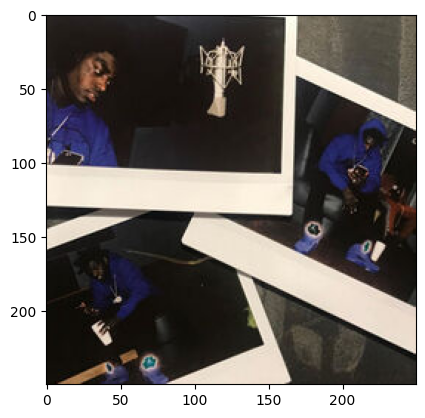

In [21]:
q.album_cover(4184)

In [22]:
q.get_info_about_album(3198)

{'title': 'Уроборос: Улица 36', 'artist': 'Скриптонит', 'genre': 'Rap/Hip Hop'}

In [23]:
albums = [3198, 4404, 2429, 1601, 3309, 2328, 3487, 3588, 5901]

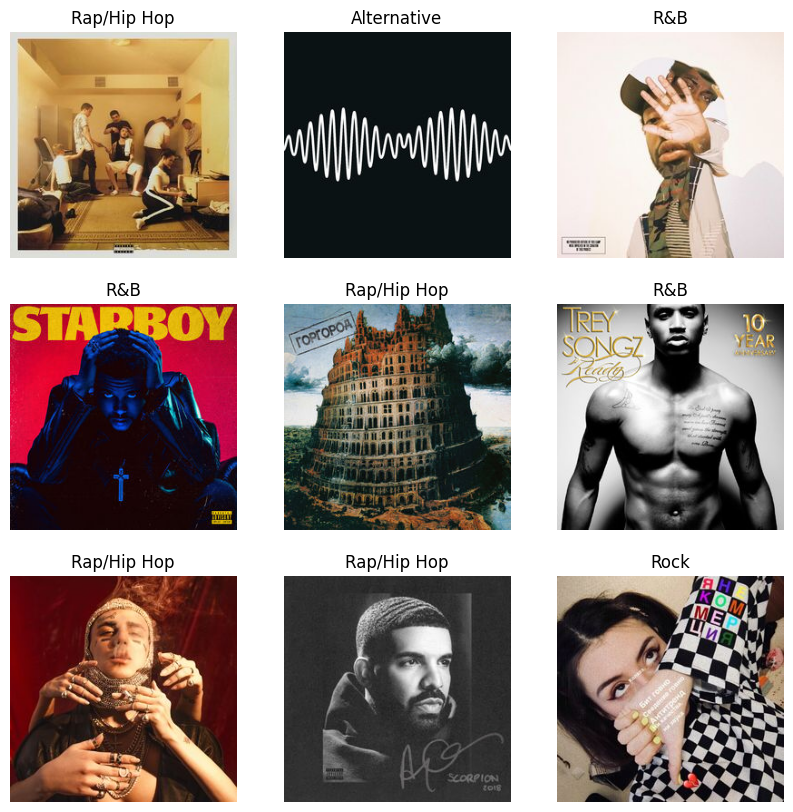

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

c = 0

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(q.get_numpy_of_image(albums[c]))
        ax[i][j].set(title=q.get_info_about_album(albums[c])['genre'])
        ax[i][j].axis('off')
        
        c += 1

plt.show()

# DataLoader

In [25]:
data_transform = transforms.Compose([
#     transforms.RandomSizedCrop(224),
    transforms.ToTensor(),
    transforms.Resize(224),
#     transforms.RandomHorizontalFlip(p=0.25),
#     transforms.RandomVerticalFlip(p=0.25),
#     transforms.RandomRotation(degrees=(-5, 5)),
#     transforms.Lambda(lambda t: t / 255.),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [38]:
train_dataset = GenresDataset(df_slice='train', transform=data_transform)
test_dataset = GenresDataset(df_slice='test', transform=data_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Model itself!

In [27]:
from torchvision import models
from torchvision.utils import make_grid

In [ ]:
model = models.vgg19(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

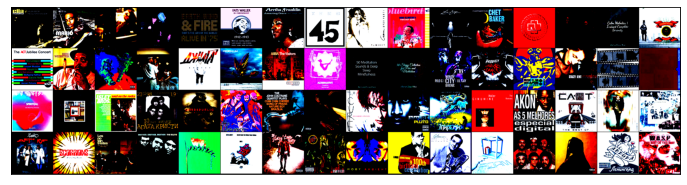

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dataloader)

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
for param in model.parameters():
    param.requires_grad = False

    
model.classifier[6]=torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(model.classifier[6].in_features, 8)),
    ('activation1', torch.nn.Softmax())
]))

for param in model.classifier[6].parameters():
    param.requires_grad = True

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# for images, labels in train_dataloader:
#     print(labels[0])
#     print('images.shape:', images.shape)
#     images, labels = images.cuda(), labels.cuda()
#     out = model(images)
#     print('out.shape:', out.shape)
#     print('out[0]:', out[0])
#     break

In [39]:
%%time

NUM_EPOCHS = 5

import torch.optim as optim
import torch.nn.functional as F

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch_train_accuracies = []
epoch_train_losses = []

epoch_val_accuracies = []
epoch_val_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"epoch={epoch}")
    a=0

    correct = 0
    running_loss = 0

    for images, labels in iter(train_dataloader):
        print(a)
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze()
        # print(f"epoch={epoch}, n_batch={a}")
        a = a + 1
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).float().sum()
        


    epoch_train_losses.append(running_loss / len(train_dataloader))
    epoch_train_accuracies.append(correct / len(train_dataset))

    val_correct = 0
    val_running_loss = 0
    
    for images, labels in iter(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

        val_running_loss += loss.item()
        val_correct += (outputs.argmax(1) == labels).float().sum()

    epoch_val_losses.append(val_running_loss / len(test_dataloader))
    epoch_val_accuracies.append(val_correct / len(test_dataset))

    print(f"Train loss={epoch_train_losses[-1]}")
    print(f"Val accuracy={epoch_val_accuracies[-1]}")

epoch=0
0
1
2


KeyboardInterrupt: 

In [35]:
print('haha')

haha


In [28]:
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}

In [29]:
class VGGnet(torch.nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(VGGnet, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types["VGG19"])

        self.fcs = torch.nn.Sequential(
            torch.nn.Linear(512 * 7 * 7, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    torch.nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    torch.nn.BatchNorm2d(x),
                    torch.nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return torch.nn.Sequential(*layers)

In [30]:
model = VGGnet(in_channels=3, num_classes=8).to(device)
print(model)

VGGnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), 

In [ ]:
epoch_train_accuracies

[tensor(0.1212, device='cuda:0'),
 tensor(0.1262, device='cuda:0'),
 tensor(0.1247, device='cuda:0'),
 tensor(0.1251, device='cuda:0'),
 tensor(0.1267, device='cuda:0'),
 tensor(0.1197, device='cuda:0'),
 tensor(0.1140, device='cuda:0'),
 tensor(0.1207, device='cuda:0'),
 tensor(0.1205, device='cuda:0'),
 tensor(0.1222, device='cuda:0'),
 tensor(0.1182, device='cuda:0'),
 tensor(0.1217, device='cuda:0')]

In [ ]:
epoch_val_accuracies

[tensor(0.5055, device='cuda:0'),
 tensor(0.7020, device='cuda:0'),
 tensor(0.7631, device='cuda:0'),
 tensor(0.7939, device='cuda:0'),
 tensor(0.8135, device='cuda:0'),
 tensor(0.8232, device='cuda:0'),
 tensor(0.8214, device='cuda:0'),
 tensor(0.8346, device='cuda:0'),
 tensor(0.8417, device='cuda:0'),
 tensor(0.8485, device='cuda:0')]

TypeError: ignored

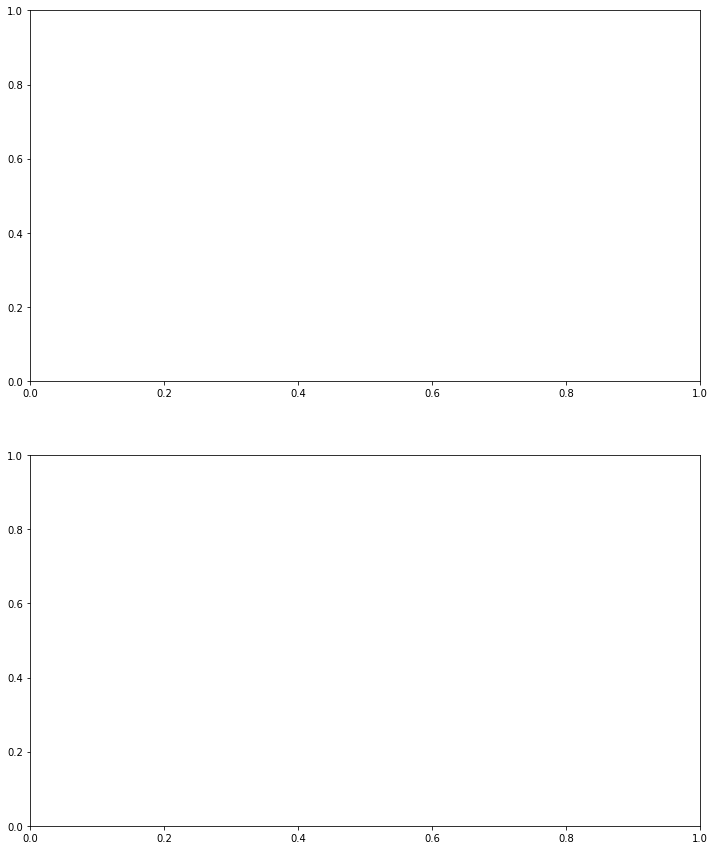

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(12, 15))


ax1.plot(epoch_train_accuracies.numpy())
ax1.plot(epoch_val_accuracies)
ax1.set_xlabel('Epoch')
ax1.grid()
ax1.legend(['Training', 'Validation'])
ax1.set_title('Accuracy')

ax2.plot(epoch_train_losses)
ax2.plot(epoch_val_losses)
ax2.set_xlabel('Epoch')
ax2.grid()
ax2.legend(['Training', 'Validation'])
ax2.set_title('Loss')

plt.show()